# Biodiversity Intactness of Phoenix, AZ
**Author**: Sofia Sarak
**Github Repository:** 

## Overview

The following notebook contains analyses exploring the biodiversity in the Pheonix area using Biodiversity Intactness Index (BII) data from the STAC catalog. 

### Highlights
1.
2.
3.

### Data

**Biodiversity Intactness Index:** BII data is accessed through the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). We use the 2017 and 2020 rasters, cropping to the Phoenix area.

**Phoenix Subdivision:** Pheonix geometry data is sourced from ____.

## Setup

In [32]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from shapely import box

from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

import contextily as ctx # For basemap

## Accessing BII Data 

### Preparation for catalog search

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

To properly access our data of interest, there are a few variables we need to specify beforehand.

First, our catalog search will require a `datetime` input, since we have specific years we want to search for. We can specify two string objects that contain the range of dates we want -- January 1st through December 31st for both 2017 and 2020.

In [3]:
# Specify date ranges and set as objects
range_2017 = "2017-01-01/2017-12-31"
range_2020 = "2020-01-01/2020-12-31"

The catalog search will also require a bounding box (bbox) to search within, as we have a specific area that we wish to gather data for. We can create a bbox using `[x_min, y_min, x_max, y_max]` coordinates for the Phoenix area.

In [4]:
# Creating bbox of Phoenix region
phoenix_bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

The last piece of information we need to know is the name of the STAC collection we wish to retrieve. In our case, this is `io-biodiversity`.

Now that we have the date range, bbox, and name of collection, we can do a catalog search for our data. We will do this twice to find data for both 2017 and 2020.

### Perform catalog search

In [6]:
## 2017
# Search MPC datalog
search_2017 = catalog.search(collections = ['io-biodiversity'],
                            bbox = phoenix_bbox,
                            datetime = range_2017)

# Retrieve search items
items_2017 = search_2017.item_collection()
print(f"Returned {len(items_2017)} length")

## 2020
# Search MPC datalog
search_2020 = catalog.search(collections = ['io-biodiversity'],
                            bbox = phoenix_bbox,
                            datetime = range_2020)

# Retrieve search items
items_2020 = search_2020.item_collection()
print(f"Returned {len(items_2020)} length")

Returned 1 length
Returned 1 length


From our print statements, we know that each item we retrieved from the catalog only has object in it. We can gather more information about our catalog search by accessing the item asset keys and their descriptions. 

In [10]:
# Save the first (and only) item from our search
item_2017 = items_2017[0]

# Print assets for 2017
for key in item_2017.assets.keys():
    print(key, '--', item_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [11]:
# Save the first (and only) item from our search
item_2020 = items_2020[0]

# Print assets for 2020
for key in item_2020.assets.keys():
    print(key, '--', item_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


We now know that both of our data files contain biodiversity intactness data, TileJSON information, and a rendered preview. Let's take a look at our 2017 rendered previews!

In [ ]:
# Preview rendered image of BII within our Pheonix bbox
Image(url = item_2017.assets['rendered_preview'].href, width=500)

### BII Data Summary

From our preliminary exploration, we have obtained 2017 and 2020 data for BII within the Phoenix bounding box. 

We know that the actual BII data is stored within the "data" asset of our search items, and we have a visual of what the 2017 data looks like.

## Phoenix Subdivision

### Load in Data

In [19]:
# Use os to build filepath to Arizona subdivision data
fp = os.path.join('data','tl_2020_04_cousub','tl_2020_04_cousub.shp')

# Read in data using geopandas
subs = gpd.read_file(fp)

### Data Exploration

In [ ]:
# Return first three rows of data frame
subs.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."


In [ ]:
# Data types stored within each column
subs.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
GEOID         object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CNECTAFP      object
NECTAFP       object
NCTADVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [ ]:
# Shape of data frame returned as (# of rows, # of columns)
subs.shape

(80, 19)

In [ ]:
# Is one of the subdivisions correspond to Phoenix?
if "Phoenix" in subs['NAME'].values:
    print('Phoenix stored as subdivision')

# Check lowercase version as well, just in case
if "phoenix" in subs['NAME'].values:
    print('Phoenix stored as subdivision')

Phoenix stored as subdivision


### Subdivision Data Summary

From our exploration, we know that this dataset stores 19 variables, but the ones of interest to us are perhaps `NAME`, where the name of each Arizone county/subdivision is stored, as well as the geometry data that we will have to use to clip and plot. We also confirmed that those two variables are stored as we would expect them to be: a string and a geometry, respectively.

In our final code chunk, we were able to confirm that there is an observation stored under Phoenix, making the filtering process in our next steps quite simple!

### Extract Phoenix Geometry and Plot

In [30]:
# Filter subs df for just the Phoenix subdivision
phoenix_sub = subs[subs['NAME'] == "Phoenix"]

# Confirm we get back one row of data
phoenix_sub

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
46,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2805901266,10048820,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


<Axes: >

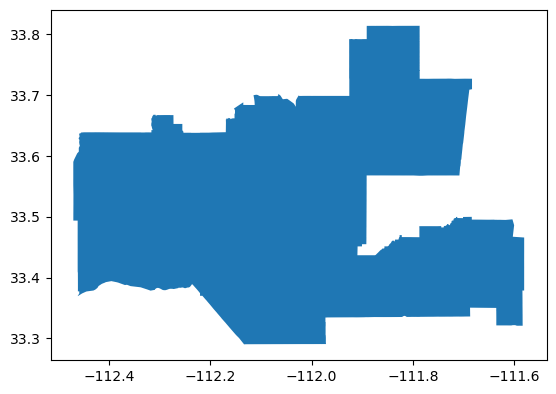

In [31]:
# Preliminary plot to see Phoenix shape/confirm geometry is stored properly
phoenix_sub.plot()

### Phoenix in Context

We will lot the boundary using a basemap from the `contextily` package to help us better visualize the area we are working with!

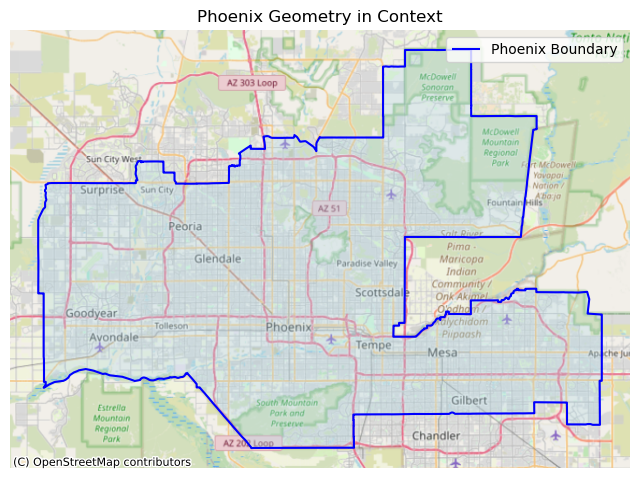

In [ ]:
# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot phoenix_sub (fill)
phoenix_sub.plot(ax = ax,
                color = "lightblue",
                alpha = 0.3)

# Plot phoenix_sub (boundary)
phoenix_sub.boundary.plot(ax=ax,
                          color = "blue",
                          label = "Phoenix Boundary")

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik,
               crs = phoenix_sub.crs)

# Add legend (using labels from .plot()) and title
plt.legend()
plt.title('Phoenix Geometry in Context')

# Turn of axes as they don't give us any beneficial information
ax.axis('off')

plt.show()

Note to self: I wonder if I can access Arizona shape from state shapefiles, and plot contextily basemap using that, and then plot phoenix on the inside

### Clip BII to Area of Interest

In [3]:
bii = catalog.get_child('io-biodiversity')

In [23]:
search_2017 = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = range_2017)

search_2017

In [24]:
# Retrieve search items
items = search_2017.item_collection()
len(items)

1

In [ ]:
polygon = {
    "type": "Polygon",
    "coordinates": [[
        [-112.826843, 32.974108],
        [-111.184387, 32.974108],
        [-111.184387, 33.863574],
        [-112.826843, 33.863574],
        [-112.826843, 32.974108]  # close polygon
    ]]
}

search_2017 = catalog.search(
    collections=["io-biodiversity"],
    intersects=polygon,
    datetime="2017-01-01/2017-12-31"
)
items = search_2017.item_collection()


In [13]:
items = search_2017.item_collection()
len(items)

1

In [14]:
item = items[0]


In [25]:
# Print item ID and properties
print('ID:' , item.id)
item.properties

ID: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z',
 'proj:code': 'EPSG:4326'}

In [26]:
 item.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2017/bii_2017_34.74464974521749_-115.38597824385106_cog.tif?st=2025-12-01T14%3A23%3A53Z&se=2025-12-02T15%3A08%3A53Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-12-02T04%3A20%3A53Z&ske=2025-12-09T04%3A20%3A53Z&sks=b&skv=2025-07-05&sig=MvsoAYKCIkK0zkOUu6Oe/8KMHbiGrBVFXBQJ4osm5zA%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97

In [27]:
for key in item.assets.keys():
    print(key, '--', item.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [28]:
# Plot rendered preview
Image(url=item.assets['rendered_preview'].href, width=500)

In [55]:
bii = rioxr.open_rasterio(item.assets['data'].href)

In [14]:
fp = os.path.join('data','tl_2020_04_cousub','tl_2020_04_cousub.shp')
counties = gpd.read_file(fp)

In [ ]:
counties.head()

In [30]:
pheonix.head()

<xarray.DataArray (band: 1, y: 5, x: 5)> Size: 100B
[25 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 40B -115.4 -115.4 -115.4 -115.4 -115.4
  * y            (y) float64 40B 34.74 34.74 34.74 34.74 34.74
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [31]:
print(type(pheonix.values))

<class 'numpy.ndarray'>


In [32]:
print("Size of dimensions: ", dict(pheonix.sizes))

Size of dimensions:  {'band': 1, 'y': 7992, 'x': 7992}


In [33]:
print('CRS: ', pheonix.rio.crs)

CRS:  EPSG:4326


In [38]:
counties = counties.to_crs(pheonix.rio.crs)

In [15]:
pheonix_county = counties[counties['NAME'] == "Phoenix"]

In [16]:
pheonix_county.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
46,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2805901266,10048820,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


<Axes: >

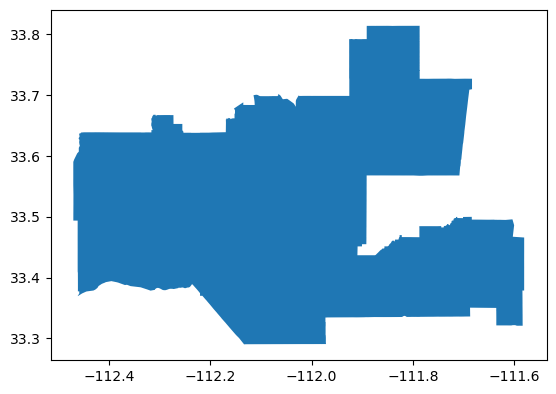

In [17]:
pheonix_county.plot()

In [56]:
bii_phoenix = bii.rio.clip_box(*pheonix_county.total_bounds)

In [57]:
print('Original shape: ', bii.shape)
print('Clipped shape: ', bii_phoenix.shape) # make sure that the shape is smaller!

Original shape:  (1, 7992, 7992)
Clipped shape:  (1, 584, 992)


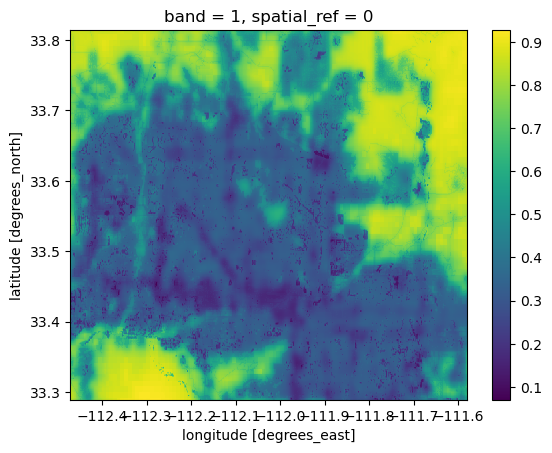

In [60]:
bii_phoenix.plot()

In [ ]:
bii_phoenix_clip = gpd.clip(bii_phoenix, pheonix_county)

TypeError: 'gdf' should be GeoDataFrame or GeoSeries, got <class 'xarray.core.dataarray.DataArray'>